[View in Colaboratory](https://colab.research.google.com/github/alonshmilo/MachineLearningJCE/blob/master/cifar10_EXAMPLE_alonshmilo.ipynb)

In [0]:

import sys
import os
import urllib.request
import tarfile
import zipfile

########################################################################


def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()


########################################################################


def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.

    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"

    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")


########################################################################

import numpy as np
import pickle
import os

def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-Hot encoded class-labels from an array of integers.
    For example, if class_number=2 and num_classes=4 then
    the one-hot encoded label is the float array: [0. 0. 1. 0.]
    :param class_numbers:
        Array of integers with class-numbers.
        Assume the integers are from zero to num_classes-1 inclusive.
    :param num_classes:
        Number of classes. If None then use max(class_numbers)+1.
    :return:
        2-dim array of shape: [len(class_numbers), num_classes]
    """

    # Find the number of classes if None is provided.
    # Assumes the lowest class-number is zero.
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]

########################################################################

# Directory where you want to download and save the data-set.
# Set this before you start calling any of the functions below.
data_path = "data/CIFAR-10/"

# URL for the data-set on the internet.
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

########################################################################
# Various constants for the size of the images.
# Use these constants in your own program.

# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = 10

########################################################################
# Various constants used to allocate arrays of the correct size.

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

########################################################################
# Private functions for downloading, unpacking and loading data-files.


def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set.

    If filename=="" then return the directory of the files.
    """

    return os.path.join(data_path, "cifar-10-batches-py/", filename)


def _unpickle(filename):
    """
    Unpickle the given file and return the data.

    Note that the appropriate dir-name is prepended the filename.
    """

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file, encoding='bytes')

    return data


def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


########################################################################
# Public functions that you may call to download the data-set from
# the internet and load the data into memory.


def maybe_download_and_extract1():
    """
    Download and extract the CIFAR-10 data-set if it doesn't already exist
    in data_path (set this variable first to the desired path).
    """

    maybe_download_and_extract(url=data_url, download_dir=data_path)


def load_class_names():
    """
    Load the names for the classes in the CIFAR-10 data-set.

    Returns a list with the names. Example: names[3] is the name
    associated with class-number 3.
    """

    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names


def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.

    The data-set is split into 5 data-files which are merged here.

    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


def load_test_data():
    """
    Load all the test-data for the CIFAR-10 data-set.

    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    images, cls = _load_data(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)

########################################################################

In [3]:
maybe_download_and_extract1()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [4]:
images_train, cls_train, labels_train = load_training_data()


Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [5]:
images_test, cls_test, labels_test = load_test_data()


Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [6]:


print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

- Training-set:		50000
- Test-set:		10000


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


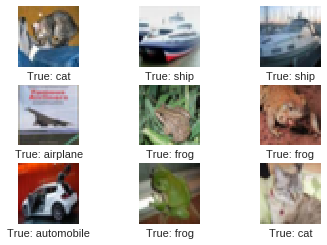

In [8]:
class_names = load_class_names()
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)



# Using Tensorflow train the fallowing network and report accuracy and loss

1.  1-FC network 
2.  2-FC network
3. 1-CONV, 1-FC
4. 2-CONV, 2-FC



# Using TF-SLIM train the fallowing network and report accuracy and loss

1.  1-FC network
2.  2-FC network
3. 1-CONV, 1-FC
4. 2-CONV, 2-FC
5. VGG16

In each network start with


*  check the loss before training (should be 2.3)
*  train on 10 images (one from each class)




In [0]:
import tensorflow.contrib.slim as slim

In [0]:
import tensorflow as tf

In [0]:
from matplotlib.ticker import MaxNLocator
import numpy as np
def plot_results(loss, acc, title):
  acc = np.array(acc) * max(loss)
    
  plt.plot(range(len(loss)), loss)
  plt.plot(range(len(acc)), acc)
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.xlabel('Training steps')
  plt.ylabel('Loss & Accuracy (0 to 1)')
  plt.title(title)
  plt.gca().legend(('Loss', 'Accuracy'))
  plt.show()



In [12]:
N, D, H = 10, 32*32*3, 10
x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, H))

#init = tf.contrib.layers.xavier_initializer()
init = tf.zeros_initializer()

h = tf.layers.dense(inputs=x,  
                    units=H,
                    activation=tf.nn.relu, 
                    kernel_initializer=init)

y_pred = tf.layers.dense(inputs=h, 
                         units=H,
                         kernel_initializer=init)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_pred)
 
optimizer = tf.train.GradientDescentOptimizer(1e0)
updates = optimizer.minimize(loss)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  values = {x: np.random.randn(N, D),
            y: np.eye(N),}
  for t in range(1):
    loss_val, _ = sess.run([loss, updates],
                          feed_dict=values)
    print(loss_val)

[2.3025851 2.3025851 2.3025851 2.3025851 2.3025851 2.3025851 2.3025851
 2.3025851 2.3025851 2.3025851]


# TensorFlow

## 1-fc network

Step 0, loss 19.1, accuracy 0.0
Step 1, loss 15.6, accuracy 0.2
Step 2, loss 20.5, accuracy 0.2
Step 3, loss 11.6, accuracy 0.1
Step 4, loss 6.66, accuracy 0.2
Step 5, loss 2.41, accuracy 0.3
Step 6, loss 5.11, accuracy 0.2
Step 7, loss 1.54, accuracy 0.3
Step 8, loss 2.29, accuracy 0.2
Step 9, loss 1.96, accuracy 0.3
Step 10, loss 1.91, accuracy 0.3
Step 11, loss 2.24, accuracy 0.2
Step 12, loss 0.124, accuracy 0.2
Step 13, loss 0.868, accuracy 0.2
Step 14, loss 0.108, accuracy 0.2
Step 15, loss 1.51, accuracy 0.3
Step 16, loss 1.13, accuracy 0.3
Step 17, loss 0.986, accuracy 0.2
Step 18, loss 0.0647, accuracy 0.1
Step 19, loss 0.00182, accuracy 0.3


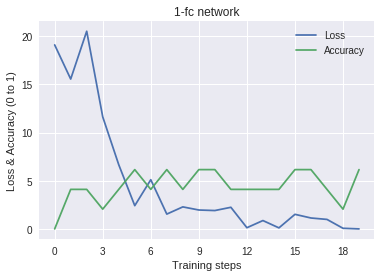

In [18]:
# 1-FC network
N, D, H = 10, 32*32*3, 10
max_steps = 500
best_loss = 0.01

tf.reset_default_graph()

def my_network(input_data, reuse, train):
  with tf.variable_scope('my_network', reuse=reuse):
    init = tf.random_normal_initializer()
    
    h_layer = tf.layers.dense(inputs=input_data,
                             units=1024,
                             activation=tf.nn.relu,
                             kernel_initializer=init)
    dropout = tf.layers.dropout(inputs=h_layer,
                               rate=0.1,
                               training=train)
    return tf.layers.dense(inputs=dropout, units=H)

  
x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, H))

logits_train = my_network(input_data=x, reuse=False, train=True)
logits_test = my_network(input_data=x, reuse=True, train=False)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,
                                                  logits=logits_train)

optimizer = tf.train.AdamOptimizer()

updates = optimizer.minimize(loss)

good_pred = tf.equal(tf.argmax(logits_test, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(good_pred, tf.float32))

acc_list=[]
loss_list=[]
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in range(max_steps):
    for b in range(int((len(images_train)/N)/100)):
      training_images = [i.flatten() for i in images_train[b * N:b * N + N]]
      training_labels = labels_train[b * N:b * N + N]
      values = {x: training_images,
               y: training_labels, }
      loss_value, _ = sess.run([loss, updates], feed_dict=values)
   
    for b in range(int((len(images_test)/N)/100)):
      testing_images = [i.flatten() for i in images_test[b * N:b * N + N]]
      testing_labels = labels_test[b * N:b * N + N]
      values = {x: testing_images,
               y: testing_labels, }
      accuracy_value = sess.run(accuracy, feed_dict = values)
    
    print("Step {}, loss {:.3g}, accuracy {:.1f}".
          format(step, np.average(loss_value), accuracy_value, 1))
    acc_list.append(accuracy_value)
    loss_list.append(np.average(loss_value))
  
    if np.max(loss_value) <= best_loss:
      break
plot_results(loss_list, acc_list, '1-fc network')

## 2-fc network

Step 0, loss 3.89e+05, accuracy 0.0
Step 1, loss 2.45e+05, accuracy 0.1
Step 2, loss 2.47e+05, accuracy 0.1
Step 3, loss 1.97e+05, accuracy 0.0
Step 4, loss 2.15e+05, accuracy 0.1
Step 5, loss 1.4e+05, accuracy 0.0
Step 6, loss 1.45e+05, accuracy 0.0
Step 7, loss 6.98e+04, accuracy 0.0
Step 8, loss 9.49e+04, accuracy 0.1
Step 9, loss 5.63e+04, accuracy 0.0
Step 10, loss 4.99e+04, accuracy 0.0
Step 11, loss 1.78e+04, accuracy 0.1
Step 12, loss 4.6e+03, accuracy 0.0
Step 13, loss 821, accuracy 0.0
Step 14, loss 107, accuracy 0.0
Step 15, loss 21.1, accuracy 0.2
Step 16, loss 2.06, accuracy 0.1
Step 17, loss 5.03, accuracy 0.2
Step 18, loss 1.82, accuracy 0.0
Step 19, loss 2.8, accuracy 0.0
Step 20, loss 1.75, accuracy 0.0
Step 21, loss 1.55, accuracy 0.0
Step 22, loss 1.57, accuracy 0.0
Step 23, loss 1.7, accuracy 0.0
Step 24, loss 1.8, accuracy 0.0
Step 25, loss 1.9, accuracy 0.0
Step 26, loss 1.45, accuracy 0.0
Step 27, loss 2.85, accuracy 0.0
Step 28, loss 1.58, accuracy 0.0
Step 29, 

Step 76, loss 1.27, accuracy 0.1
Step 77, loss 1.33, accuracy 0.1
Step 78, loss 1.36, accuracy 0.1
Step 79, loss 1.57, accuracy 0.1
Step 80, loss 1.74, accuracy 0.1
Step 81, loss 1.43, accuracy 0.1
Step 82, loss 1.36, accuracy 0.1
Step 83, loss 1.22, accuracy 0.0
Step 84, loss 1.3, accuracy 0.1
Step 85, loss 1.47, accuracy 0.1
Step 86, loss 1.2, accuracy 0.0
Step 87, loss 1.42, accuracy 0.0
Step 88, loss 1.47, accuracy 0.0
Step 89, loss 1.21, accuracy 0.1
Step 90, loss 1.59, accuracy 0.0
Step 91, loss 1.43, accuracy 0.0
Step 92, loss 1.55, accuracy 0.0
Step 93, loss 1.63, accuracy 0.0
Step 94, loss 1.46, accuracy 0.1
Step 95, loss 1.43, accuracy 0.0
Step 96, loss 1.84, accuracy 0.0
Step 97, loss 1.34, accuracy 0.1
Step 98, loss 2.18, accuracy 0.0
Step 99, loss 1.37, accuracy 0.1
Step 100, loss 1.56, accuracy 0.1
Step 101, loss 1.61, accuracy 0.1
Step 102, loss 1.7, accuracy 0.0
Step 103, loss 1.57, accuracy 0.1
Step 104, loss 1.66, accuracy 0.1
Step 105, loss 1.51, accuracy 0.0
Step 10

Step 152, loss 2.04, accuracy 0.1
Step 153, loss 2.04, accuracy 0.1
Step 154, loss 2.03, accuracy 0.1
Step 155, loss 2.03, accuracy 0.1
Step 156, loss 1.94, accuracy 0.1
Step 157, loss 2.02, accuracy 0.1
Step 158, loss 1.9, accuracy 0.1
Step 159, loss 1.89, accuracy 0.1
Step 160, loss 1.92, accuracy 0.1
Step 161, loss 2.67, accuracy 0.1
Step 162, loss 2.03, accuracy 0.1
Step 163, loss 1.88, accuracy 0.1
Step 164, loss 2.02, accuracy 0.1
Step 165, loss 2.02, accuracy 0.1
Step 166, loss 2.01, accuracy 0.1
Step 167, loss 2.03, accuracy 0.1
Step 168, loss 2.02, accuracy 0.1
Step 169, loss 1.89, accuracy 0.1
Step 170, loss 2.03, accuracy 0.1
Step 171, loss 2.04, accuracy 0.1
Step 172, loss 2.03, accuracy 0.1
Step 173, loss 2.06, accuracy 0.1
Step 174, loss 2.01, accuracy 0.1
Step 175, loss 2.02, accuracy 0.1
Step 176, loss 2.04, accuracy 0.1
Step 177, loss 2.03, accuracy 0.1
Step 178, loss 2.03, accuracy 0.1
Step 179, loss 2.02, accuracy 0.1
Step 180, loss 2.02, accuracy 0.1
Step 181, loss 

Step 228, loss 2.02, accuracy 0.1
Step 229, loss 2.02, accuracy 0.1
Step 230, loss 2.03, accuracy 0.1
Step 231, loss 2.02, accuracy 0.1
Step 232, loss 2.04, accuracy 0.1
Step 233, loss 2.02, accuracy 0.1
Step 234, loss 2.02, accuracy 0.1
Step 235, loss 2.02, accuracy 0.1
Step 236, loss 2.01, accuracy 0.1
Step 237, loss 2.02, accuracy 0.1
Step 238, loss 2.02, accuracy 0.1
Step 239, loss 2.04, accuracy 0.1
Step 240, loss 2.02, accuracy 0.1
Step 241, loss 2.02, accuracy 0.1
Step 242, loss 2.02, accuracy 0.1
Step 243, loss 2.02, accuracy 0.1
Step 244, loss 2.02, accuracy 0.1
Step 245, loss 2.02, accuracy 0.1
Step 246, loss 2.01, accuracy 0.1
Step 247, loss 2.03, accuracy 0.1
Step 248, loss 2.03, accuracy 0.1
Step 249, loss 1.99, accuracy 0.1
Step 250, loss 2.02, accuracy 0.1
Step 251, loss 2.04, accuracy 0.1
Step 252, loss 2.03, accuracy 0.1
Step 253, loss 2.02, accuracy 0.1
Step 254, loss 2.03, accuracy 0.1
Step 255, loss 2.03, accuracy 0.1
Step 256, loss 2.01, accuracy 0.1
Step 257, loss

Step 304, loss 2.02, accuracy 0.1
Step 305, loss 2.02, accuracy 0.1
Step 306, loss 2.03, accuracy 0.1
Step 307, loss 2.04, accuracy 0.1
Step 308, loss 2.02, accuracy 0.1
Step 309, loss 2.03, accuracy 0.1
Step 310, loss 2.02, accuracy 0.1
Step 311, loss 2.03, accuracy 0.1
Step 312, loss 2.01, accuracy 0.1
Step 313, loss 2.04, accuracy 0.1
Step 314, loss 2.02, accuracy 0.1
Step 315, loss 2.03, accuracy 0.1
Step 316, loss 2.03, accuracy 0.1
Step 317, loss 2.03, accuracy 0.1
Step 318, loss 2.05, accuracy 0.1
Step 319, loss 2.02, accuracy 0.1
Step 320, loss 2.02, accuracy 0.1
Step 321, loss 2.04, accuracy 0.1
Step 322, loss 2.03, accuracy 0.1
Step 323, loss 2.02, accuracy 0.1
Step 324, loss 2.04, accuracy 0.1
Step 325, loss 2.04, accuracy 0.1
Step 326, loss 2.03, accuracy 0.0
Step 327, loss 2.03, accuracy 0.0
Step 328, loss 2.03, accuracy 0.0
Step 329, loss 2.04, accuracy 0.0
Step 330, loss 2.03, accuracy 0.0
Step 331, loss 2.02, accuracy 0.0
Step 332, loss 2.03, accuracy 0.1
Step 333, loss

Step 380, loss 2.03, accuracy 0.1
Step 381, loss 2.02, accuracy 0.1
Step 382, loss 2.02, accuracy 0.0
Step 383, loss 2.01, accuracy 0.0
Step 384, loss 2.02, accuracy 0.1
Step 385, loss 2.02, accuracy 0.1
Step 386, loss 2.01, accuracy 0.0
Step 387, loss 2.03, accuracy 0.1
Step 388, loss 2.11, accuracy 0.2
Step 389, loss 2.03, accuracy 0.1
Step 390, loss 2.04, accuracy 0.0
Step 391, loss 2.01, accuracy 0.0
Step 392, loss 2.03, accuracy 0.0
Step 393, loss 2.03, accuracy 0.1
Step 394, loss 2.02, accuracy 0.1
Step 395, loss 2.03, accuracy 0.1
Step 396, loss 2.01, accuracy 0.0
Step 397, loss 2.03, accuracy 0.0
Step 398, loss 2.03, accuracy 0.1
Step 399, loss 2.03, accuracy 0.0
Step 400, loss 2.03, accuracy 0.0
Step 401, loss 2.03, accuracy 0.1
Step 402, loss 2.03, accuracy 0.1
Step 403, loss 2.03, accuracy 0.0
Step 404, loss 2.04, accuracy 0.1
Step 405, loss 2.02, accuracy 0.1
Step 406, loss 2.03, accuracy 0.1
Step 407, loss 2.03, accuracy 0.1
Step 408, loss 2.02, accuracy 0.1
Step 409, loss

Step 456, loss 2.02, accuracy 0.1
Step 457, loss 2.03, accuracy 0.0
Step 458, loss 2.03, accuracy 0.0
Step 459, loss 2.02, accuracy 0.1
Step 460, loss 2.02, accuracy 0.1
Step 461, loss 2.02, accuracy 0.0
Step 462, loss 2.02, accuracy 0.0
Step 463, loss 2.05, accuracy 0.1
Step 464, loss 2.03, accuracy 0.1
Step 465, loss 2.02, accuracy 0.1
Step 466, loss 2.01, accuracy 0.0
Step 467, loss 2.02, accuracy 0.0
Step 468, loss 2.03, accuracy 0.1
Step 469, loss 2.04, accuracy 0.1
Step 470, loss 2.01, accuracy 0.0
Step 471, loss 2.03, accuracy 0.0
Step 472, loss 2.02, accuracy 0.1
Step 473, loss 2.02, accuracy 0.0
Step 474, loss 2.02, accuracy 0.1
Step 475, loss 2.02, accuracy 0.1
Step 476, loss 2.03, accuracy 0.1
Step 477, loss 2.04, accuracy 0.0
Step 478, loss 2.03, accuracy 0.0
Step 479, loss 2.03, accuracy 0.0
Step 480, loss 2.02, accuracy 0.0
Step 481, loss 2.03, accuracy 0.0
Step 482, loss 2.03, accuracy 0.0
Step 483, loss 2.02, accuracy 0.0
Step 484, loss 2.03, accuracy 0.1
Step 485, loss

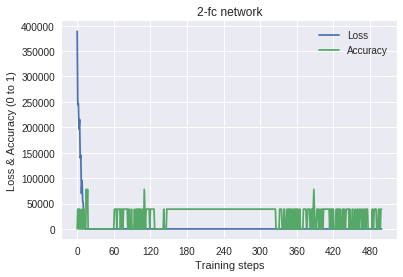

In [19]:
#2-FC network

N, D, H = 10, 32 * 32 * 3, 10
max_steps = 500
best_loss = 0.01

tf.reset_default_graph()

def my_network(input_data, reuse, train):
  with tf.variable_scope('my_network', reuse=reuse):
    init = tf.random_uniform_initializer()
    
    h1_layer = tf.layers.dense(inputs=input_data,
                              units=1024,
                              activation=tf.nn.relu,
                              kernel_initializer=init)
    dropout1 = tf.layers.dropout(inputs=h1_layer,
                                rate=0.1,
                                training=train)
    
    
    h2_layer = tf.layers.dense(inputs=dropout1,
                               units=1024,
                              activation=tf.nn.relu,
                              kernel_initializer=init)
    
    dropout2 = tf.layers.dropout(inputs=h2_layer,
                               rate=0.1,
                               training=train)
    
    return tf.layers.dense(inputs=dropout2, units=H)
 
x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, H))

logits_train = my_network(input_data=x, reuse=False, train=True)
logits_test = my_network(input_data=x, reuse=True, train=False)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,
                                                 logits=logits_train)

optimizer = tf.train.AdamOptimizer()

updates = optimizer.minimize(loss)

good_pred = tf.equal(tf.argmax(logits_test, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(good_pred, tf.float32))

acc_list=[]
loss_list=[]
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in range(max_steps):
    for b in range(int((len(images_train)/N)/100)):
      training_images = [i.flatten() for i in images_train[b * N:b * N + N]]
      training_labesl = labels_train[b* N:b *N + N]
      
      values = {x: training_images,
               y: training_labels, }
      
      loss_value, _ = sess.run([loss, updates], feed_dict=values)
      
    for b in range(int((len(images_test)/N)/100)):
      testing_images = [i.flatten() for i in images_test[b * N:b * N+ N]]
      testing_labels = labels_test[b * N:b * N + N]
      
      values = {x: testing_images,
               y: testing_labels, }
      
      accuracy_value = sess.run(accuracy, feed_dict=values)
      
    print("Step {}, loss {:.3g}, accuracy {:.1f}".
         format(step, np.average(loss_value), accuracy_value, 1))
    
    acc_list.append(accuracy_value)
    loss_list.append(np.average(loss_value))    
    
    if np.max(loss_value) <=best_loss:
      break

plot_results(loss_list, acc_list, '2-fc network')

## 1-conv 1-fc network

Step 0, loss 2.22, accuracy 0.3
Step 1, loss 1.82, accuracy 0.1
Step 2, loss 1.3, accuracy 0.3
Step 3, loss 0.906, accuracy 0.4
Step 4, loss 0.924, accuracy 0.4
Step 5, loss 1.51, accuracy 0.3
Step 6, loss 1.09, accuracy 0.6
Step 7, loss 0.59, accuracy 0.3
Step 8, loss 0.365, accuracy 0.3
Step 9, loss 0.464, accuracy 0.2
Step 10, loss 0.322, accuracy 0.2
Step 11, loss 0.466, accuracy 0.2
Step 12, loss 0.232, accuracy 0.3
Step 13, loss 0.338, accuracy 0.3
Step 14, loss 1.09, accuracy 0.3
Step 15, loss 0.0147, accuracy 0.4
Step 16, loss 0.00745, accuracy 0.3
Step 17, loss 0.00297, accuracy 0.3
Step 18, loss 0.00112, accuracy 0.4


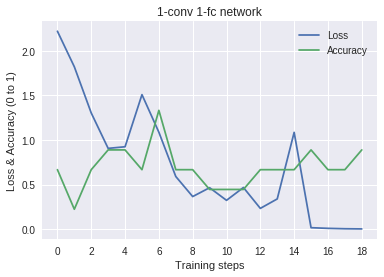

In [20]:
#1-FC 1-CONV network
N, D, H = 10, 32*32*3, 10
max_steps = 500
best_loss = 0.01

tf.reset_default_graph()

def my_network(input_data, reuse, train):
  with tf.variable_scope('my_network', reuse=reuse):
    init = tf.random_normal_initializer()
    
    #conv1 = conv-layer
    conv1 = tf.layers.conv2d(inputs=input_data,
                            filters=32,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    
    #conv1 = reshape
    conv1 = tf.reshape(conv1, [N, 32*32*32])
    
    h_layer = tf.layers.dense(inputs=conv1,
                             units=4096,
                             activation=tf.nn.relu,
                             kernel_initializer=init)
    
    dropout = tf.layers.dropout(inputs=h_layer,
                               rate=0.1,
                               training=train)
    return tf.layers.dense(inputs=dropout, units=H)

  
x = tf.placeholder(tf.float32, shape=(N,32,32,3))
y = tf.placeholder(tf.float32, shape=(N, H))

logits_train = my_network(input_data=x, reuse=False, train=True)
logits_test = my_network(input_data=x, reuse=True, train=False)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,
                                                  logits=logits_train)

optimizer = tf.train.AdamOptimizer()

updates = optimizer.minimize(loss)

good_pred = tf.equal(tf.argmax(logits_test, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(good_pred, tf.float32))

acc_list=[]
loss_list=[]
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in range(max_steps):
    for b in range(int((len(images_train)/N)/100)):
      training_images = images_train[b * N:b * N + N]
      training_labels = labels_train[b * N:b * N + N]
      values = {x: training_images,
               y: training_labels, }
      loss_value, _ = sess.run([loss, updates], feed_dict=values)
   
    for b in range(int((len(images_test)/N)/100)):
      testing_images = images_test[b * N:b * N + N]
      testing_labels = labels_test[b * N:b * N + N]
      values = {x: testing_images,
               y: testing_labels, }
      accuracy_value = sess.run(accuracy, feed_dict = values)
    
    print("Step {}, loss {:.3g}, accuracy {:.1f}".
          format(step, np.average(loss_value), accuracy_value, 1))
    
    acc_list.append(accuracy_value)
    loss_list.append(np.average(loss_value))
    
    
  
    if np.max(loss_value) <= best_loss:
      break

plot_results(loss_list, acc_list, '1-conv 1-fc network')


## 2-fc 2-conv network

In [0]:
#2-FC 2-CONV network

N, D, H = 10, 32 * 32 * 3, 10
max_steps = 500
best_loss = 0.01

tf.reset_default_graph()

def my_network(input_data, reuse, train):
  with tf.variable_scope('my_network', reuse=reuse):
    init = tf.random_uniform_initializer()
    
    
    #conv1layer
    conv1 = tf.layers.conv2d(inputs=input_data,
                            filters=32,
                            kernel_size=[3,3],
                            padding="same",
                            activation=tf.nn.relu)    
    #conv2layer
    conv2 = tf.layers.conv2d(inputs=conv1,
                            filters=32,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    
    
    #reshape
    conv2 = tf.reshape(conv2, [N, 32*32*32])

    
    h1_layer = tf.layers.dense(inputs=conv2,
                              units=4096,
                              activation=tf.nn.relu,
                              kernel_initializer=init)
    
    dropout1 = tf.layers.dropout(inputs=h1_layer,
                                rate=0.1,
                                training=train)
    
    
    h2_layer = tf.layers.dense(inputs=dropout1,
                               units=1024,
                              activation=tf.nn.relu,
                              kernel_initializer=init)
    
    dropout2 = tf.layers.dropout(inputs=h2_layer,
                               rate=0.1,
                               training=train)
    
    return tf.layers.dense(inputs=dropout2, units=H)

x = tf.placeholder(tf.float32, shape=(N, 32,32,3))
y = tf.placeholder(tf.float32, shape=(N, H))

logits_train = my_network(input_data=x, reuse=False, train=True)
logits_test = my_network(input_data=x, reuse=True, train=False)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,
                                                 logits=logits_train)

optimizer = tf.train.AdamOptimizer()

updates = optimizer.minimize(loss)

good_pred = tf.equal(tf.argmax(logits_test, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(good_pred, tf.float32))

acc_list=[]
loss_list=[]
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in range(max_steps):
    for b in range(int((len(images_train)/N)/100)):
      training_images = images_train[b * N:b * N + N]
      training_labesl = labels_train[b* N:b *N + N]
      
      values = {x: training_images,
               y: training_labels, }
      
      loss_value, _ = sess.run([loss, updates], feed_dict=values)
      
    for b in range(int((len(images_test)/N)/100)):
      testing_images = images_test[b * N:b * N + N]
      testing_labels = labels_test[b * N:b * N + N]
      
      values = {x: testing_images,
               y: testing_labels, }
      
      accuracy_value = sess.run(accuracy, feed_dict=values)
      
    print("Step {}, loss {:.3g}, accuracy {:.1f}".
         format(step, np.average(loss_value), accuracy_value, 1))
    
    acc_list.append(accuracy_value)
    loss_list.append(np.average(loss_value))
    
    
    
    if np.max(loss_value) <=best_loss:
      break
      
      
plot_results(loss_list, acc_list, '2conv 2-fc network')  

Step 0, loss 2.19, accuracy 0.1
Step 1, loss 2.07, accuracy 0.1
Step 2, loss 2.03, accuracy 0.1
Step 3, loss 2.04, accuracy 0.1
Step 4, loss 2.03, accuracy 0.1
Step 5, loss 2.03, accuracy 0.1
Step 6, loss 2.03, accuracy 0.1
Step 7, loss 2.02, accuracy 0.1
Step 8, loss 2.02, accuracy 0.1
Step 9, loss 2.03, accuracy 0.1
Step 10, loss 2.03, accuracy 0.1
Step 11, loss 2.03, accuracy 0.1
Step 12, loss 2.04, accuracy 0.1
Step 13, loss 2.03, accuracy 0.1
Step 14, loss 2.04, accuracy 0.1
Step 15, loss 2.02, accuracy 0.1
Step 16, loss 2.02, accuracy 0.1
Step 17, loss 2.02, accuracy 0.1
Step 18, loss 2.03, accuracy 0.1
Step 19, loss 2.03, accuracy 0.1
Step 20, loss 2.03, accuracy 0.1
Step 21, loss 2.02, accuracy 0.1
Step 22, loss 2.03, accuracy 0.1
Step 23, loss 2.03, accuracy 0.1
Step 24, loss 2.03, accuracy 0.1
Step 25, loss 2.04, accuracy 0.1
Step 26, loss 2.02, accuracy 0.1
Step 27, loss 2.03, accuracy 0.1
Step 28, loss 2.03, accuracy 0.0
Step 29, loss 2.03, accuracy 0.0
Step 30, loss 2.03, 

Step 77, loss 2.02, accuracy 0.0
Step 78, loss 2.03, accuracy 0.0
Step 79, loss 2.04, accuracy 0.1
Step 80, loss 2.03, accuracy 0.1
Step 81, loss 2.03, accuracy 0.1
Step 82, loss 2.02, accuracy 0.0
Step 83, loss 2.03, accuracy 0.0
Step 84, loss 2.02, accuracy 0.0
Step 85, loss 2.03, accuracy 0.1
Step 86, loss 2.04, accuracy 0.0
Step 87, loss 2.04, accuracy 0.1
Step 88, loss 2.01, accuracy 0.1
Step 89, loss 2.05, accuracy 0.0
Step 90, loss 2.02, accuracy 0.1
Step 91, loss 2.05, accuracy 0.1
Step 92, loss 2.03, accuracy 0.0
Step 93, loss 2.04, accuracy 0.1
Step 94, loss 2.03, accuracy 0.0
Step 95, loss 2.04, accuracy 0.1
Step 96, loss 2.03, accuracy 0.0
Step 97, loss 2.05, accuracy 0.0
Step 98, loss 2.03, accuracy 0.1
Step 99, loss 2.02, accuracy 0.0
Step 100, loss 2.03, accuracy 0.1
Step 101, loss 2.02, accuracy 0.0
Step 102, loss 2.02, accuracy 0.1
Step 103, loss 2.04, accuracy 0.1
Step 104, loss 2.03, accuracy 0.0
Step 105, loss 2.02, accuracy 0.1
Step 106, loss 2.02, accuracy 0.0
Ste

Step 153, loss 2.04, accuracy 0.0
Step 154, loss 2.01, accuracy 0.0
Step 155, loss 2.02, accuracy 0.1
Step 156, loss 2.02, accuracy 0.0
Step 157, loss 2.02, accuracy 0.0
Step 158, loss 2.02, accuracy 0.1
Step 159, loss 2.03, accuracy 0.0
Step 160, loss 2.03, accuracy 0.0
Step 161, loss 2.02, accuracy 0.0
Step 162, loss 2.04, accuracy 0.0
Step 163, loss 2.02, accuracy 0.0
Step 164, loss 2.01, accuracy 0.1
Step 165, loss 2.02, accuracy 0.0
Step 166, loss 2.03, accuracy 0.0
Step 167, loss 2.01, accuracy 0.1
Step 168, loss 2.04, accuracy 0.0
Step 169, loss 2.02, accuracy 0.0
Step 170, loss 2.02, accuracy 0.0
Step 171, loss 2.03, accuracy 0.0
Step 172, loss 2.03, accuracy 0.0
Step 173, loss 2.03, accuracy 0.0
Step 174, loss 2.02, accuracy 0.0
Step 175, loss 2.02, accuracy 0.1
Step 176, loss 2.02, accuracy 0.1
Step 177, loss 2.01, accuracy 0.0
Step 178, loss 2.01, accuracy 0.1
Step 179, loss 2.03, accuracy 0.0
Step 180, loss 2.03, accuracy 0.1
Step 181, loss 2.03, accuracy 0.0
Step 182, loss

# Slim

## 1-fc network

Step 0, loss 4.11, accuracy 0.1
Step 1, loss 2.63, accuracy 0.1
Step 2, loss 2.25, accuracy 0.1
Step 3, loss 1.69, accuracy 0.2
Step 4, loss 1.6, accuracy 0.2
Step 5, loss 1.95, accuracy 0.2
Step 6, loss 1.65, accuracy 0.2
Step 7, loss 1.69, accuracy 0.2
Step 8, loss 1.58, accuracy 0.3
Step 9, loss 1.72, accuracy 0.3
Step 10, loss 1.51, accuracy 0.3
Step 11, loss 1.7, accuracy 0.4
Step 12, loss 1.8, accuracy 0.2
Step 13, loss 1.94, accuracy 0.2
Step 14, loss 1.37, accuracy 0.4
Step 15, loss 1.64, accuracy 0.3
Step 16, loss 1.7, accuracy 0.3
Step 17, loss 1.61, accuracy 0.4
Step 18, loss 1.36, accuracy 0.4
Step 19, loss 1.63, accuracy 0.5
Step 20, loss 1.29, accuracy 0.5
Step 21, loss 1.36, accuracy 0.4
Step 22, loss 1.33, accuracy 0.4
Step 23, loss 1.31, accuracy 0.5
Step 24, loss 0.974, accuracy 0.3
Step 25, loss 1.25, accuracy 0.3
Step 26, loss 1.44, accuracy 0.5
Step 27, loss 1.29, accuracy 0.5
Step 28, loss 1.36, accuracy 0.5
Step 29, loss 1.43, accuracy 0.4
Step 30, loss 1.52, acc

Step 77, loss 0.842, accuracy 0.6
Step 78, loss 0.826, accuracy 0.5
Step 79, loss 0.663, accuracy 0.5
Step 80, loss 1.38, accuracy 0.5
Step 81, loss 0.875, accuracy 0.3
Step 82, loss 1.53, accuracy 0.6
Step 83, loss 0.644, accuracy 0.5
Step 84, loss 0.498, accuracy 0.5
Step 85, loss 1.24, accuracy 0.5
Step 86, loss 1.47, accuracy 0.6
Step 87, loss 0.699, accuracy 0.4
Step 88, loss 0.512, accuracy 0.5
Step 89, loss 0.816, accuracy 0.6
Step 90, loss 0.799, accuracy 0.6
Step 91, loss 0.636, accuracy 0.4
Step 92, loss 0.781, accuracy 0.6
Step 93, loss 0.995, accuracy 0.5
Step 94, loss 0.418, accuracy 0.4
Step 95, loss 1.05, accuracy 0.5
Step 96, loss 0.529, accuracy 0.5
Step 97, loss 0.782, accuracy 0.5
Step 98, loss 1.5, accuracy 0.5
Step 99, loss 0.924, accuracy 0.5
Step 100, loss 0.468, accuracy 0.5
Step 101, loss 1.32, accuracy 0.5
Step 102, loss 1.15, accuracy 0.6
Step 103, loss 0.504, accuracy 0.5
Step 104, loss 0.608, accuracy 0.5
Step 105, loss 0.415, accuracy 0.5
Step 106, loss 0.

Step 152, loss 0.112, accuracy 0.6
Step 153, loss 0.69, accuracy 0.4
Step 154, loss 0.906, accuracy 0.5
Step 155, loss 0.59, accuracy 0.5
Step 156, loss 0.621, accuracy 0.5
Step 157, loss 1.12, accuracy 0.6
Step 158, loss 0.941, accuracy 0.4
Step 159, loss 0.776, accuracy 0.5
Step 160, loss 0.415, accuracy 0.6
Step 161, loss 0.699, accuracy 0.5
Step 162, loss 0.551, accuracy 0.6
Step 163, loss 0.874, accuracy 0.4
Step 164, loss 0.663, accuracy 0.4
Step 165, loss 0.339, accuracy 0.5
Step 166, loss 1.16, accuracy 0.3
Step 167, loss 0.702, accuracy 0.5
Step 168, loss 0.875, accuracy 0.4
Step 169, loss 0.92, accuracy 0.6
Step 170, loss 0.42, accuracy 0.4
Step 171, loss 0.326, accuracy 0.5
Step 172, loss 0.597, accuracy 0.4
Step 173, loss 0.365, accuracy 0.5
Step 174, loss 0.54, accuracy 0.5
Step 175, loss 0.562, accuracy 0.4
Step 176, loss 1.39, accuracy 0.6
Step 177, loss 0.922, accuracy 0.6
Step 178, loss 0.167, accuracy 0.4
Step 179, loss 0.314, accuracy 0.5
Step 180, loss 0.506, accura

Step 227, loss 0.477, accuracy 0.5
Step 228, loss 0.453, accuracy 0.5
Step 229, loss 0.722, accuracy 0.5
Step 230, loss 1.05, accuracy 0.4
Step 231, loss 1.26, accuracy 0.6
Step 232, loss 0.905, accuracy 0.3
Step 233, loss 0.522, accuracy 0.4
Step 234, loss 0.713, accuracy 0.5
Step 235, loss 0.22, accuracy 0.4
Step 236, loss 0.347, accuracy 0.5
Step 237, loss 0.44, accuracy 0.5
Step 238, loss 0.598, accuracy 0.5
Step 239, loss 0.896, accuracy 0.4
Step 240, loss 0.614, accuracy 0.6
Step 241, loss 0.36, accuracy 0.5
Step 242, loss 0.628, accuracy 0.4
Step 243, loss 0.517, accuracy 0.5
Step 244, loss 0.263, accuracy 0.4
Step 245, loss 0.33, accuracy 0.5
Step 246, loss 0.18, accuracy 0.5
Step 247, loss 0.675, accuracy 0.5
Step 248, loss 0.709, accuracy 0.5
Step 249, loss 0.132, accuracy 0.5
Step 250, loss 0.313, accuracy 0.5
Step 251, loss 0.302, accuracy 0.4
Step 252, loss 0.382, accuracy 0.7
Step 253, loss 0.701, accuracy 0.5
Step 254, loss 0.988, accuracy 0.5
Step 255, loss 0.868, accur

Step 302, loss 0.515, accuracy 0.6
Step 303, loss 1.3, accuracy 0.4
Step 304, loss 0.423, accuracy 0.5
Step 305, loss 0.869, accuracy 0.3
Step 306, loss 0.427, accuracy 0.5
Step 307, loss 0.594, accuracy 0.5
Step 308, loss 0.481, accuracy 0.5
Step 309, loss 0.237, accuracy 0.4
Step 310, loss 0.326, accuracy 0.5
Step 311, loss 0.289, accuracy 0.4
Step 312, loss 0.746, accuracy 0.5
Step 313, loss 0.149, accuracy 0.5
Step 314, loss 0.538, accuracy 0.4
Step 315, loss 0.54, accuracy 0.6
Step 316, loss 0.266, accuracy 0.4
Step 317, loss 0.675, accuracy 0.3
Step 318, loss 0.498, accuracy 0.5
Step 319, loss 0.282, accuracy 0.5
Step 320, loss 0.374, accuracy 0.4
Step 321, loss 0.342, accuracy 0.5
Step 322, loss 0.333, accuracy 0.4
Step 323, loss 0.911, accuracy 0.5
Step 324, loss 0.494, accuracy 0.4
Step 325, loss 0.719, accuracy 0.6
Step 326, loss 0.204, accuracy 0.6
Step 327, loss 0.213, accuracy 0.6
Step 328, loss 0.201, accuracy 0.6
Step 329, loss 0.366, accuracy 0.4
Step 330, loss 0.399, a

Step 377, loss 0.435, accuracy 0.4
Step 378, loss 0.684, accuracy 0.4
Step 379, loss 0.444, accuracy 0.5
Step 380, loss 0.278, accuracy 0.4
Step 381, loss 0.902, accuracy 0.4
Step 382, loss 0.472, accuracy 0.4
Step 383, loss 0.873, accuracy 0.4
Step 384, loss 0.375, accuracy 0.5
Step 385, loss 0.603, accuracy 0.5
Step 386, loss 0.53, accuracy 0.5
Step 387, loss 0.296, accuracy 0.4
Step 388, loss 0.239, accuracy 0.4
Step 389, loss 0.575, accuracy 0.4
Step 390, loss 0.396, accuracy 0.3
Step 391, loss 0.349, accuracy 0.4
Step 392, loss 0.227, accuracy 0.5
Step 393, loss 0.227, accuracy 0.5
Step 394, loss 0.257, accuracy 0.5
Step 395, loss 0.294, accuracy 0.5
Step 396, loss 0.412, accuracy 0.4
Step 397, loss 0.371, accuracy 0.5
Step 398, loss 0.241, accuracy 0.5
Step 399, loss 0.93, accuracy 0.5
Step 400, loss 0.522, accuracy 0.5
Step 401, loss 0.153, accuracy 0.6
Step 402, loss 0.249, accuracy 0.5
Step 403, loss 0.651, accuracy 0.5
Step 404, loss 0.395, accuracy 0.5
Step 405, loss 0.425, 

Step 452, loss 0.809, accuracy 0.4
Step 453, loss 0.272, accuracy 0.4
Step 454, loss 0.169, accuracy 0.4
Step 455, loss 0.304, accuracy 0.6
Step 456, loss 0.129, accuracy 0.6
Step 457, loss 0.444, accuracy 0.3
Step 458, loss 0.304, accuracy 0.5
Step 459, loss 0.854, accuracy 0.4
Step 460, loss 0.278, accuracy 0.5
Step 461, loss 0.205, accuracy 0.6
Step 462, loss 0.444, accuracy 0.4
Step 463, loss 0.384, accuracy 0.3
Step 464, loss 0.354, accuracy 0.5
Step 465, loss 0.153, accuracy 0.3
Step 466, loss 0.59, accuracy 0.4
Step 467, loss 0.159, accuracy 0.4
Step 468, loss 0.407, accuracy 0.5
Step 469, loss 0.46, accuracy 0.6
Step 470, loss 0.131, accuracy 0.4
Step 471, loss 1.08, accuracy 0.6
Step 472, loss 0.332, accuracy 0.4
Step 473, loss 0.447, accuracy 0.3
Step 474, loss 0.755, accuracy 0.5
Step 475, loss 0.248, accuracy 0.5
Step 476, loss 0.286, accuracy 0.4
Step 477, loss 0.714, accuracy 0.5
Step 478, loss 0.911, accuracy 0.4
Step 479, loss 0.547, accuracy 0.5
Step 480, loss 0.663, a

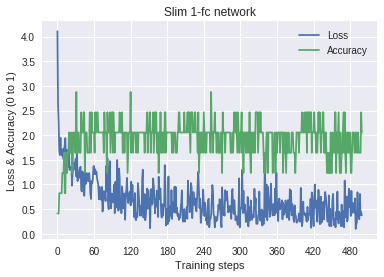

In [66]:
#Slim 1-FC network
N, D, H = 10, 32*32*3, 10
max_steps = 500
best_loss = 0.01

tf.reset_default_graph()

def my_network(input_data, reuse, train):
  with tf.variable_scope('my_network', reuse=reuse):
    init = tf.random_normal_initializer()
    
    fc = slim.fully_connected(input_data,
                             4096,
                             scope='fc1',
                             reuse=reuse)
    
    dropout = slim.dropout(fc,
                          keep_prob=0.6,
                          is_training=train)
    
    return slim.fully_connected(dropout,
                               H,
                               activation_fn=None,
                               scope='layer',
                               reuse=reuse)

  
x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, H))

logits_train = my_network(input_data=x, reuse=False, train=True)
logits_test = my_network(input_data=x, reuse=True, train=False)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,
                                                  logits=logits_train)

optimizer = tf.train.AdamOptimizer()

updates = optimizer.minimize(loss)

good_pred = tf.equal(tf.argmax(logits_test, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(good_pred, tf.float32))

acc_list=[]
loss_list=[]
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in range(max_steps):
    for b in range(int((len(images_train)/N)/100)):
      training_images = [i.flatten() for i in images_train[b * N:b * N + N]]
      training_labels = labels_train[b * N:b * N + N]
      values = {x: training_images,
               y: training_labels, }
      loss_value, _ = sess.run([loss, updates], feed_dict=values)
   
    for b in range(int((len(images_test)/N)/100)):
      testing_images = [i.flatten() for i in images_test[b * N:b * N + N]]
      testing_labels = labels_test[b * N:b * N + N]
      values = {x: testing_images,
               y: testing_labels, }
      accuracy_value = sess.run(accuracy, feed_dict = values)
    
    print("Step {}, loss {:.3g}, accuracy {:.1f}".
          format(step, np.average(loss_value), accuracy_value, 1))
    
    acc_list.append(accuracy_value)
    loss_list.append(np.average(loss_value))
    
  
    if np.max(loss_value) <= best_loss:
      break
      
      
plot_results(loss_list, acc_list, 'Slim 1-fc network')

## 2-fc network

Step 0, loss 2.38, accuracy 0.2
Step 1, loss 2.36, accuracy 0.2
Step 2, loss 2.07, accuracy 0.3
Step 3, loss 2.09, accuracy 0.2
Step 4, loss 1.83, accuracy 0.3
Step 5, loss 1.86, accuracy 0.4
Step 6, loss 1.78, accuracy 0.4
Step 7, loss 2.05, accuracy 0.4
Step 8, loss 2.15, accuracy 0.0
Step 9, loss 2.25, accuracy 0.2
Step 10, loss 2.31, accuracy 0.3
Step 11, loss 2.18, accuracy 0.3
Step 12, loss 2.23, accuracy 0.2
Step 13, loss 2.06, accuracy 0.1
Step 14, loss 2.06, accuracy 0.3
Step 15, loss 2.22, accuracy 0.4
Step 16, loss 1.9, accuracy 0.3
Step 17, loss 1.81, accuracy 0.5
Step 18, loss 1.92, accuracy 0.3
Step 19, loss 1.95, accuracy 0.3
Step 20, loss 2.26, accuracy 0.3
Step 21, loss 2.31, accuracy 0.1
Step 22, loss 2.64, accuracy 0.3
Step 23, loss 2.19, accuracy 0.4
Step 24, loss 2.11, accuracy 0.1
Step 25, loss 1.97, accuracy 0.3
Step 26, loss 2.16, accuracy 0.3
Step 27, loss 1.92, accuracy 0.2
Step 28, loss 2.3, accuracy 0.3
Step 29, loss 2.33, accuracy 0.3
Step 30, loss 2.47, ac

Step 77, loss 2.19, accuracy 0.3
Step 78, loss 2.05, accuracy 0.2
Step 79, loss 1.99, accuracy 0.3
Step 80, loss 2.22, accuracy 0.2
Step 81, loss 1.81, accuracy 0.4
Step 82, loss 1.96, accuracy 0.2
Step 83, loss 1.82, accuracy 0.2
Step 84, loss 1.73, accuracy 0.2
Step 85, loss 2.16, accuracy 0.2
Step 86, loss 2.13, accuracy 0.4
Step 87, loss 2.39, accuracy 0.1
Step 88, loss 2.2, accuracy 0.2
Step 89, loss 1.96, accuracy 0.3
Step 90, loss 2.05, accuracy 0.1
Step 91, loss 2.17, accuracy 0.2
Step 92, loss 1.97, accuracy 0.2
Step 93, loss 2.2, accuracy 0.2
Step 94, loss 2.11, accuracy 0.2
Step 95, loss 2.16, accuracy 0.2
Step 96, loss 2.16, accuracy 0.4
Step 97, loss 2.11, accuracy 0.2
Step 98, loss 2.05, accuracy 0.2
Step 99, loss 2.04, accuracy 0.3
Step 100, loss 1.65, accuracy 0.2
Step 101, loss 2, accuracy 0.3
Step 102, loss 2.2, accuracy 0.2
Step 103, loss 2.23, accuracy 0.1
Step 104, loss 2.3, accuracy 0.1
Step 105, loss 1.8, accuracy 0.2
Step 106, loss 2, accuracy 0.3
Step 107, loss

Step 154, loss 1.96, accuracy 0.3
Step 155, loss 1.88, accuracy 0.2
Step 156, loss 2.17, accuracy 0.2
Step 157, loss 1.77, accuracy 0.1
Step 158, loss 1.91, accuracy 0.3
Step 159, loss 1.86, accuracy 0.1
Step 160, loss 1.93, accuracy 0.1
Step 161, loss 2.19, accuracy 0.2
Step 162, loss 2.23, accuracy 0.2
Step 163, loss 2.09, accuracy 0.1
Step 164, loss 2.15, accuracy 0.2
Step 165, loss 1.99, accuracy 0.1
Step 166, loss 2.12, accuracy 0.1
Step 167, loss 2.15, accuracy 0.1
Step 168, loss 2.36, accuracy 0.1
Step 169, loss 1.8, accuracy 0.2
Step 170, loss 2.22, accuracy 0.1
Step 171, loss 2.11, accuracy 0.2
Step 172, loss 1.99, accuracy 0.1
Step 173, loss 1.77, accuracy 0.2
Step 174, loss 1.89, accuracy 0.2
Step 175, loss 1.83, accuracy 0.1
Step 176, loss 2.03, accuracy 0.3
Step 177, loss 1.88, accuracy 0.2
Step 178, loss 2.15, accuracy 0.1
Step 179, loss 1.58, accuracy 0.4
Step 180, loss 2.29, accuracy 0.3
Step 181, loss 2.01, accuracy 0.2
Step 182, loss 1.63, accuracy 0.2
Step 183, loss 

Step 230, loss 2.13, accuracy 0.3
Step 231, loss 1.98, accuracy 0.2
Step 232, loss 2.25, accuracy 0.2
Step 233, loss 1.89, accuracy 0.3
Step 234, loss 2.02, accuracy 0.2
Step 235, loss 1.94, accuracy 0.2
Step 236, loss 1.66, accuracy 0.2
Step 237, loss 1.9, accuracy 0.2
Step 238, loss 2.25, accuracy 0.4
Step 239, loss 1.62, accuracy 0.5
Step 240, loss 1.85, accuracy 0.3
Step 241, loss 1.78, accuracy 0.4
Step 242, loss 1.97, accuracy 0.5
Step 243, loss 2.19, accuracy 0.5
Step 244, loss 2.08, accuracy 0.4
Step 245, loss 2.15, accuracy 0.4
Step 246, loss 2.15, accuracy 0.3
Step 247, loss 1.96, accuracy 0.2
Step 248, loss 1.97, accuracy 0.3
Step 249, loss 1.94, accuracy 0.3
Step 250, loss 1.92, accuracy 0.2
Step 251, loss 2.04, accuracy 0.2
Step 252, loss 1.66, accuracy 0.2
Step 253, loss 2.15, accuracy 0.1
Step 254, loss 2.25, accuracy 0.2
Step 255, loss 1.83, accuracy 0.2
Step 256, loss 1.74, accuracy 0.2
Step 257, loss 1.71, accuracy 0.2
Step 258, loss 1.89, accuracy 0.2
Step 259, loss 

Step 306, loss 1.9, accuracy 0.2
Step 307, loss 1.54, accuracy 0.2
Step 308, loss 2.18, accuracy 0.1
Step 309, loss 2.13, accuracy 0.2
Step 310, loss 2.11, accuracy 0.3
Step 311, loss 1.85, accuracy 0.2
Step 312, loss 1.46, accuracy 0.2
Step 313, loss 1.67, accuracy 0.2
Step 314, loss 1.93, accuracy 0.2
Step 315, loss 1.48, accuracy 0.2
Step 316, loss 1.65, accuracy 0.2
Step 317, loss 1.7, accuracy 0.4
Step 318, loss 2.14, accuracy 0.1
Step 319, loss 1.95, accuracy 0.3
Step 320, loss 1.65, accuracy 0.3
Step 321, loss 1.63, accuracy 0.4
Step 322, loss 1.86, accuracy 0.2
Step 323, loss 1.46, accuracy 0.2
Step 324, loss 1.95, accuracy 0.2
Step 325, loss 1.86, accuracy 0.2
Step 326, loss 2.16, accuracy 0.2
Step 327, loss 2.15, accuracy 0.2
Step 328, loss 1.48, accuracy 0.2
Step 329, loss 1.8, accuracy 0.2
Step 330, loss 1.64, accuracy 0.2
Step 331, loss 2.03, accuracy 0.2
Step 332, loss 1.68, accuracy 0.2
Step 333, loss 1.92, accuracy 0.2
Step 334, loss 2.29, accuracy 0.2
Step 335, loss 2.

Step 382, loss 2.15, accuracy 0.2
Step 383, loss 2.18, accuracy 0.1
Step 384, loss 1.78, accuracy 0.2
Step 385, loss 1.86, accuracy 0.3
Step 386, loss 2.02, accuracy 0.2
Step 387, loss 1.73, accuracy 0.1
Step 388, loss 1.89, accuracy 0.4
Step 389, loss 1.84, accuracy 0.5
Step 390, loss 1.95, accuracy 0.4
Step 391, loss 2.39, accuracy 0.3
Step 392, loss 1.94, accuracy 0.4
Step 393, loss 1.86, accuracy 0.4
Step 394, loss 1.6, accuracy 0.4
Step 395, loss 2.15, accuracy 0.4
Step 396, loss 1.93, accuracy 0.3
Step 397, loss 1.84, accuracy 0.1
Step 398, loss 1.66, accuracy 0.1
Step 399, loss 2.35, accuracy 0.3
Step 400, loss 2.14, accuracy 0.1
Step 401, loss 2.1, accuracy 0.2
Step 402, loss 1.85, accuracy 0.2
Step 403, loss 1.61, accuracy 0.2
Step 404, loss 1.84, accuracy 0.2
Step 405, loss 2, accuracy 0.2
Step 406, loss 2.16, accuracy 0.2
Step 407, loss 1.72, accuracy 0.2
Step 408, loss 1.53, accuracy 0.2
Step 409, loss 1.63, accuracy 0.2
Step 410, loss 1.84, accuracy 0.2
Step 411, loss 1.79

Step 458, loss 2.05, accuracy 0.3
Step 459, loss 2.02, accuracy 0.1
Step 460, loss 2.07, accuracy 0.2
Step 461, loss 1.5, accuracy 0.1
Step 462, loss 2.35, accuracy 0.1
Step 463, loss 2.3, accuracy 0.1
Step 464, loss 2.28, accuracy 0.1
Step 465, loss 2.31, accuracy 0.1
Step 466, loss 1.94, accuracy 0.1
Step 467, loss 1.4, accuracy 0.2
Step 468, loss 1.84, accuracy 0.3
Step 469, loss 1.65, accuracy 0.2
Step 470, loss 1.82, accuracy 0.2
Step 471, loss 1.88, accuracy 0.2
Step 472, loss 2.2, accuracy 0.1
Step 473, loss 2.34, accuracy 0.2
Step 474, loss 1.94, accuracy 0.2
Step 475, loss 1.44, accuracy 0.2
Step 476, loss 2.31, accuracy 0.1
Step 477, loss 2.31, accuracy 0.1
Step 478, loss 2.17, accuracy 0.0
Step 479, loss 2.2, accuracy 0.0
Step 480, loss 2.17, accuracy 0.0
Step 481, loss 2.28, accuracy 0.0
Step 482, loss 2.14, accuracy 0.0
Step 483, loss 2.27, accuracy 0.0
Step 484, loss 2.28, accuracy 0.0
Step 485, loss 2.19, accuracy 0.0
Step 486, loss 2.3, accuracy 0.0
Step 487, loss 2.27,

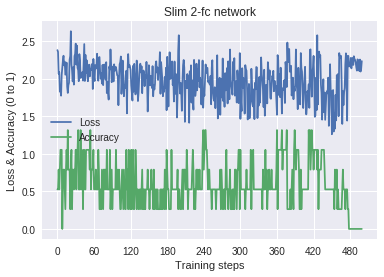

In [67]:
#Slim 2-FC network
N, D, H = 10, 32*32*3, 10
max_steps = 500
best_loss = 0.01

tf.reset_default_graph()

def my_network(input_data, reuse, train):
  with tf.variable_scope('my_network', reuse=reuse):
    init = tf.random_normal_initializer()
    
    fc1 = slim.fully_connected(input_data,
                             3072,
                             scope='fc1',
                             reuse=reuse)
    
    dropout1 = slim.dropout(fc1,
                          keep_prob=0.6,
                          is_training=train)
    
    fc2 = slim.fully_connected(dropout1,
                            4096,
                            scope='fc2',
                            reuse=reuse)
    
    dropout2 = slim.dropout(fc2,
                           keep_prob=0.6,
                           is_training=train)
    
    
    
    return slim.fully_connected(dropout2,
                               H,
                               activation_fn=None,
                               scope='layer',
                               reuse=reuse)

  
x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, H))

logits_train = my_network(input_data=x, reuse=False, train=True)
logits_test = my_network(input_data=x, reuse=True, train=False)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,
                                                  logits=logits_train)

optimizer = tf.train.AdamOptimizer()

updates = optimizer.minimize(loss)

good_pred = tf.equal(tf.argmax(logits_test, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(good_pred, tf.float32))

acc_list=[]
loss_list=[]
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in range(max_steps):
    for b in range(int((len(images_train)/N)/100)):
      training_images = [i.flatten() for i in images_train[b * N:b * N + N]]
      training_labels = labels_train[b * N:b * N + N]
      values = {x: training_images,
               y: training_labels, }
      loss_value, _ = sess.run([loss, updates], feed_dict=values)
   
    for b in range(int((len(images_test)/N)/100)):
      testing_images = [i.flatten() for i in images_test[b * N:b * N + N]]
      testing_labels = labels_test[b * N:b * N + N]
      values = {x: testing_images,
               y: testing_labels, }
      accuracy_value = sess.run(accuracy, feed_dict = values)
    
    print("Step {}, loss {:.3g}, accuracy {:.1f}".
          format(step, np.average(loss_value), accuracy_value, 1))
    
    
    acc_list.append(accuracy_value)
    loss_list.append(np.average(loss_value))
    
    if np.max(loss_value) <= best_loss:
      break

plot_results(loss_list, acc_list, 'Slim 2-fc network')


## 1-fc 1-conv network

Step 0, loss 2.23, accuracy 0.0
Step 1, loss 2.01, accuracy 0.2
Step 2, loss 1.88, accuracy 0.4
Step 3, loss 2, accuracy 0.2
Step 4, loss 1.69, accuracy 0.4
Step 5, loss 0.802, accuracy 0.3
Step 6, loss 0.61, accuracy 0.3
Step 7, loss 0.472, accuracy 0.3
Step 8, loss 0.197, accuracy 0.6
Step 9, loss 0.129, accuracy 0.2
Step 10, loss 0.292, accuracy 0.4
Step 11, loss 0.112, accuracy 0.5
Step 12, loss 0.157, accuracy 0.3
Step 13, loss 0.122, accuracy 0.6
Step 14, loss 0.071, accuracy 0.5
Step 15, loss 0.0245, accuracy 0.6
Step 16, loss 0.0283, accuracy 0.5
Step 17, loss 0.00378, accuracy 0.4
Step 18, loss 0.435, accuracy 0.6
Step 19, loss 0.0359, accuracy 0.4
Step 20, loss 0.000287, accuracy 0.4


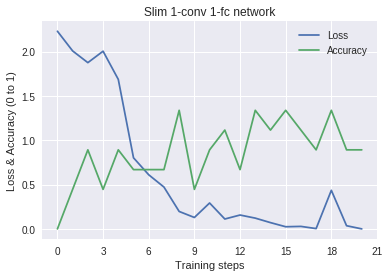

In [68]:
#Slim 1-FC 1-conv network
N, D, H = 10, 32*32*3, 10
max_steps = 500
best_loss = 0.01

tf.reset_default_graph()

def my_network(input_data, reuse, train):
  with tf.variable_scope('my_network', reuse=reuse):
    init = tf.random_normal_initializer()
    
    conv1 = slim.conv2d(input_data,
                       32,
                       [5,5],
                       padding="SAME",
                       scope='conv1',
                       reuse=reuse)
    
    
    net = slim.max_pool2d(conv1,
                          [2, 2],
                          scope='p2')
    
    net = tf.reshape(net, [N, 16*16*32])
    
    fc1 = slim.fully_connected(net,
                              512,
                              scope='fc1',
                              reuse=reuse)
    
    dropout1 = slim.dropout(fc1,
                           keep_prob=0.6,
                           is_training=train)
    
    
    fc2 = slim.fully_connected(dropout1,
                              4096,
                              scope='fc2',
                              reuse=reuse)
    
    dropout2 = slim.dropout(fc2,
                           keep_prob=0.6,
                           is_training=train)
    
    
    return slim.fully_connected(dropout2,
                               H,
                               activation_fn=None,
                               scope='layer',
                               reuse=reuse)

  
x = tf.placeholder(tf.float32, shape=(N, 32,32,3))
y = tf.placeholder(tf.float32, shape=(N, H))

logits_train = my_network(input_data=x, reuse=False, train=True)
logits_test = my_network(input_data=x, reuse=True, train=False)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,
                                                  logits=logits_train)

optimizer = tf.train.AdamOptimizer()

updates = optimizer.minimize(loss)

good_pred = tf.equal(tf.argmax(logits_test, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(good_pred, tf.float32))

acc_list=[]
loss_list=[]
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in range(max_steps):
    for b in range(int((len(images_train)/N)/100)):
      training_images = images_train[b * N:b * N + N]
      training_labels = labels_train[b * N:b * N + N]
      values = {x: training_images,
               y: training_labels, }
      loss_value, _ = sess.run([loss, updates], feed_dict=values)
   
    for b in range(int((len(images_test)/N)/100)):
      testing_images = images_test[b * N:b * N + N]
      testing_labels = labels_test[b * N:b * N + N]
      values = {x: testing_images,
               y: testing_labels, }
      accuracy_value = sess.run(accuracy, feed_dict = values)
    
    print("Step {}, loss {:.3g}, accuracy {:.1f}".
          format(step, np.average(loss_value), accuracy_value, 1))
    
    
    acc_list.append(accuracy_value)
    loss_list.append(np.average(loss_value))
    
    
  
    if np.max(loss_value) <= best_loss:
      break
      
      
plot_results(loss_list, acc_list, 'Slim 1-conv 1-fc network')


## 2-fc 2-conv network

Step 0, loss 2.28, accuracy 0.3
Step 1, loss 2.15, accuracy 0.4
Step 2, loss 1.99, accuracy 0.5
Step 3, loss 1.73, accuracy 0.4
Step 4, loss 1.49, accuracy 0.2
Step 5, loss 1.67, accuracy 0.4
Step 6, loss 1.23, accuracy 0.4
Step 7, loss 0.489, accuracy 0.4
Step 8, loss 0.587, accuracy 0.5
Step 9, loss 0.716, accuracy 0.5
Step 10, loss 0.611, accuracy 0.6
Step 11, loss 0.397, accuracy 0.6
Step 12, loss 0.556, accuracy 0.6
Step 13, loss 0.168, accuracy 0.4
Step 14, loss 0.206, accuracy 0.6
Step 15, loss 0.0486, accuracy 0.7
Step 16, loss 0.48, accuracy 0.5
Step 17, loss 0.351, accuracy 0.7
Step 18, loss 0.0842, accuracy 0.5
Step 19, loss 0.0243, accuracy 0.6
Step 20, loss 0.0568, accuracy 0.6
Step 21, loss 0.138, accuracy 0.6
Step 22, loss 0.00226, accuracy 0.6
Step 23, loss 0.0254, accuracy 0.8
Step 24, loss 0.0583, accuracy 0.7
Step 25, loss 0.0891, accuracy 0.6
Step 26, loss 0.428, accuracy 0.6
Step 27, loss 0.0304, accuracy 0.6
Step 28, loss 0.0102, accuracy 0.7
Step 29, loss 0.00357

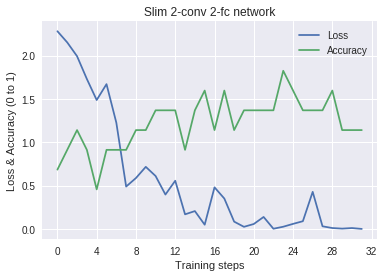

In [69]:
#Slim 2-FC network
N, D, H = 10, 32*32*3, 10
max_steps = 500
best_loss = 0.01

tf.reset_default_graph()

def my_network(input_data, reuse, train):
  with tf.variable_scope('my_network', reuse=reuse):
    init = tf.random_normal_initializer()
    
    conv1 = slim.conv2d(input_data,
                       32,
                       [5,5],
                       padding="SAME",
                       scope='conv1',
                       reuse=reuse)
    
    
    net = slim.max_pool2d(conv1,
                          [2, 2],
                          scope='p2')
    
    conv2 = slim.conv2d(net,
                       64,
                       [3,3],
                       padding="SAME",
                       scope='conv2',
                       reuse=reuse)
    
    net = slim.max_pool2d(conv2,
                          [2, 2],
                          scope='p4')
    
    net = tf.reshape(net, [N, 8*8*64])
    
    fc1 = slim.fully_connected(net,
                              512,
                              scope='fc1',
                              reuse=reuse)
    
    dropout1 = slim.dropout(fc1,
                           keep_prob=0.6,
                           is_training=train)
    
    
    fc2 = slim.fully_connected(dropout1,
                              4096,
                              scope='fc2',
                              reuse=reuse)
    
    dropout2 = slim.dropout(fc2,
                           keep_prob=0.6,
                           is_training=train)
    
    
    return slim.fully_connected(dropout2,
                               H,
                               activation_fn=None,
                               scope='layer',
                               reuse=reuse)

  
x = tf.placeholder(tf.float32, shape=(N, 32,32,3))
y = tf.placeholder(tf.float32, shape=(N, H))

logits_train = my_network(input_data=x, reuse=False, train=True)
logits_test = my_network(input_data=x, reuse=True, train=False)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,
                                                  logits=logits_train)

optimizer = tf.train.AdamOptimizer()

updates = optimizer.minimize(loss)

good_pred = tf.equal(tf.argmax(logits_test, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(good_pred, tf.float32))

acc_list=[]
loss_list=[]
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in range(max_steps):
    for b in range(int((len(images_train)/N)/100)):
      training_images = images_train[b * N:b * N + N]
      training_labels = labels_train[b * N:b * N + N]
      values = {x: training_images,
               y: training_labels, }
      loss_value, _ = sess.run([loss, updates], feed_dict=values)
   
    for b in range(int((len(images_test)/N)/100)):
      testing_images = images_test[b * N:b * N + N]
      testing_labels = labels_test[b * N:b * N + N]
      values = {x: testing_images,
               y: testing_labels, }
      accuracy_value = sess.run(accuracy, feed_dict = values)
    
    print("Step {}, loss {:.3g}, accuracy {:.1f}".
          format(step, np.average(loss_value), accuracy_value, 1))
    
    
    acc_list.append(accuracy_value)
    loss_list.append(np.average(loss_value))
    
    
  
    if np.max(loss_value) <= best_loss:
      break
      
plot_results(loss_list, acc_list, 'Slim 2-conv 2-fc network')


## vgg16

In [70]:
#Slim 1-FC 1-conv network
N, D, H = 10, 32*32*3, 10
max_steps = 500
best_loss = 0.01

tf.reset_default_graph()

def vgg16(input_data, reuse, train):
  
  with tf.variable_scope('my_network', reuse=reuse):
    init = tf.random_normal_initializer()
  
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                       activation_fn=tf.nn.relu,
                       weights_initializer=tf.truncated_normal_initializer(0.0,0.01),
                       weights_regularizer=slim.l2_regularizer(0.0005)):
      
      net = slim.conv2d(input_data, 64, 
                          [3,3],
                         padding='SAME',
                         scope='conv1',
                         reuse=reuse)
      
      net = slim.conv2d(input_data, 128, 
                          [3,3],
                         padding='SAME',
                         scope='conv2',
                         reuse=reuse)
      
      net = slim.conv2d(input_data, 256, 
                          [3,3],
                         padding='SAME',
                         scope='conv3',
                         reuse=reuse)
      
      net = slim.conv2d(input_data, 512, 
                          [3,3],
                         padding='SAME',
                         scope='conv4',
                         reuse=reuse)
      
      net = slim.conv2d(input_data, 512, 
                          [3,3],
                         padding='SAME',
                         scope='conv5',
                         reuse=reuse)

      net = slim.fully_connected(net, 4096, activation_fn=None, scope='fc6')

      
      net = slim.dropout(net, 0.5, scope='dropout7')
      net = slim.fully_connected(net, 1000, activation_fn=None, scope='fc8')
  
      return net

  
x = tf.placeholder(tf.float32, shape=(N, 32,32,3))
y = tf.placeholder(tf.float32, shape=(N, H))

logits_train = vgg16(input_data=x, reuse=False, train=True)
logits_test = vgg16(input_data=x, reuse=True, train=False)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,
                                                  logits=logits_train)

optimizer = tf.train.AdamOptimizer()

updates = optimizer.minimize(loss)

good_pred = tf.equal(tf.argmax(logits_test, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(good_pred, tf.float32))

acc_list=[]
loss_list=[]
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in range(max_steps):
    for b in range(int((len(images_train)/N)/100)):
      training_images = images_train[b * N:b * N + N]
      training_labels = labels_train[b * N:b * N + N]
      values = {x: training_images,
               y: training_labels, }
      loss_value, _ = sess.run([loss, updates], feed_dict=values)
   
    for b in range(int((len(images_test)/N)/100)):
      testing_images = images_test[b * N:b * N + N]
      testing_labels = labels_test[b * N:b * N + N]
      values = {x: testing_images,
               y: testing_labels, }
      accuracy_value = sess.run(accuracy, feed_dict = values)
    
    print("Step {}, loss {:.3g}, accuracy {:.1f}".
          format(step, np.average(loss_value), accuracy_value, 1))
    
    acc_list.append(accuracy_value)
    loss_list.append(np.average(loss_value))
    
    
  
    if np.max(loss_value) <= best_loss:
      break
      
plot_results(loss_list, acc_list, 'VGG16 network')


ValueError: ignored